# Preprocessing

## Featurizing

In [46]:
import mdtraj as md
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, Model,regularizers

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [2]:
tr = "/home/tedeschg/prj/asmsa_data/thermal_unfolding_training/new_dataset/trpcage/train_model/trpcage_ds_nH.xtc"
conf = "/home/tedeschg/prj/asmsa_data/thermal_unfolding_training/new_dataset/trpcage/train_model/trpcage_npt400_nH.pdb"
tr_de="/home/tedeschg/prj/asmsa_data/all_pdb_gro_xtc/trpcage/trpcage_reduced_fit.xtc"
conf_de="/home/tedeschg/prj/asmsa_data/all_pdb_gro_xtc/trpcage/trpcage.pdb"
traj = md.load_xtc(tr, top=conf)
#traj.image_molecules(inplace=True)
#backbone_atoms = traj.topology.select('backbone')
#traj.superpose(traj, 0, atom_indices=backbone_atoms)




In [3]:
import nglview as nv


view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
n_frames, n_atoms = traj.n_frames, traj.n_atoms #50001, 144

In [6]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

bb_indices = traj.topology.select("backbone")
n_bb = len(bb_indices)

ca_indices = traj.topology.select("name CA")
pairs = np.array([(i, j) for idx,i in enumerate(ca_indices) 
                          for j in ca_indices[idx+1:]])

coords_bb = traj.xyz[:,bb_indices,:]
#coords = traj.xyz.reshape(n_frames, n_atoms * 3) #from (n_frame, n_atoms, 3) to (n_frame, n_atoms*3) 
coords = coords_bb.reshape(n_frames, n_bb * 3)
phi_angles = md.compute_phi(traj)[1]  
psi_angles = md.compute_psi(traj)[1] 
dists = md.compute_distances(traj, pairs) 

bonds = list(traj.topology.bonds)
bond_pairs = [[b.atom1.index, b.atom2.index] for b in bonds]
bond_lengths = md.compute_distances(traj, bond_pairs)

chi1_indices, chi1_angles = md.compute_chi1(traj)
chi2_indices, chi2_angles = md.compute_chi2(traj)

In [8]:
#coords.shape[1]
bond_lengths.shape[1]

150

In [7]:
feat = np.concatenate([coords,bond_lengths,phi_angles,psi_angles,chi1_angles,chi2_angles,dists], axis=1)


In [8]:
scaler = MinMaxScaler()
feat_norm = scaler.fit_transform(feat)
feat_norm.shape

(50001, 643)

## NN preprocessing

In [9]:
import tensorflow as tf
n_samples, n_features = feat_norm.shape

train_size = 0.70
test_size = 0.15
val_size = 0.15

n_train = int(train_size * n_samples)
n_val = int(val_size * n_samples)
n_test = n_samples - n_train - n_val

batch_size=64
seed = 42

print(f'Sample:{n_samples}, Feat:{n_features}')

Sample:50001, Feat:643


In [10]:
ds = tf.data.Dataset.from_tensor_slices(feat_norm)
ds = ds.shuffle(buffer_size=n_samples, seed=seed)

ds_train = ds.take(n_train)
ds_t = ds.skip(n_train)
ds_val = ds_t.take(n_val)
ds_test = ds_t.skip(n_val)

ds_train = ds_train.map(lambda x: (x, x), num_parallel_calls=tf.data.AUTOTUNE) \
                   .batch(batch_size, drop_remainder=True) \
                   .shuffle(100) \
                   .prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(lambda x: (x, x), num_parallel_calls=tf.data.AUTOTUNE) \
               .batch(batch_size) \
               .prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(lambda x: (x, x), num_parallel_calls=tf.data.AUTOTUNE) \
                 .batch(batch_size) \
                 .prefetch(tf.data.AUTOTUNE)

ds_all = tf.data.Dataset.from_tensor_slices(feat_norm) \
                       .batch(batch_size) \
                       .prefetch(tf.data.AUTOTUNE)

print(f'Train:{len(ds_train)}, Val:{len(ds_val)}, Test:{len(ds_test)}')

I0000 00:00:1753391486.671876  332922 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Train:546, Val:118, Test:118


# AE

In [11]:
'''

Batch Norm, nel caso, va prima della layer activation)
'''

'\n\nBatch Norm, nel caso, va prima della layer activation)\n'

In [62]:
latent_dim = 2

enc_input_layer = layers.Input(shape=(n_features,), name="enc_input")

el1 = layers.Dense(128, name="enc_layer_1")(enc_input_layer)
ebl1 = layers.BatchNormalization(momentum=0.8, name="enc_bn_1")(el1)
eacl1 = layers.Activation('gelu', name="enc_gelu_1")(ebl1)
edr1  = layers.Dropout(0.2, name="enc_dropout_1")(eacl1)

el2 = layers.Dense(64, name="enc_layer_2")(edr1)
ebl2 = layers.BatchNormalization(momentum=0.8, name="enc_bn_2")(el2)
eacl2 = layers.Activation('gelu', name="enc_gelu_2")(ebl2)
edr2  = layers.Dropout(0.2, name="enc_dropout_2")(eacl2)

el3 = layers.Dense(32, name="enc_layer_3")(edr2)
ebl3 = layers.BatchNormalization(momentum=0.8, name="enc_bn_3")(el3)
eacl3 = layers.Activation('gelu', name="enc_gelu_3")(ebl3)
edr3  = layers.Dropout(0.2, name="enc_dropout_3")(eacl3)

latent = layers.Dense(latent_dim, name="latent")(edr3)
encoder = models.Model(inputs=enc_input_layer, outputs=latent, name="encoder")

dec_input_layer = layers.Input(shape=(latent_dim,), name="decoder_input")

dl1 = layers.Dense(32, name="decoder_layer_1")(dec_input_layer)
dbl1 = layers.BatchNormalization(momentum=0.8, name="dec_bn_1")(dl1)
dacl1 = layers.Activation('gelu', name="dec_gelu_1")(dbl1)
ddr1  = layers.Dropout(0.2, name="dec_dropout_1")(dacl1)

dl2 = layers.Dense(64, name="decoder_layer_2")(ddr1)
dbl2 = layers.BatchNormalization(momentum=0.8, name="dec_bn_2")(dl2)
dacl2 = layers.Activation('gelu', name="dec_gelu_2")(dbl2)
ddr2  = layers.Dropout(0.2, name="dec_dropout_2")(dacl2)

dl3 = layers.Dense(128, name="decoder_layer_3")(ddr2)
dbl3 = layers.BatchNormalization(momentum=0.8, name="dec_bn_3")(dl3)
dacl3 = layers.Activation('gelu', name="dec_gelu_3")(dbl3)
ddr3  = layers.Dropout(0.2, name="dec_dropout_3")(dacl3)

dec_output_layer = layers.Dense(n_features, activation="sigmoid", name="dec_output_layer")(ddr3)
decoder = models.Model(inputs=dec_input_layer, outputs=dec_output_layer, name="decoder")

# --- Autoencoder ---
autoencoder = models.Model(inputs=enc_input_layer, outputs=decoder(encoder(enc_input_layer)), name="autoencoder")
autoencoder.compile(optimizer="adam", loss="mse")

#autoencoder.summary()


In [63]:
import datetime

log_dir = "/home/tedeschg/prj/ASMSA/mydev/logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,        # salva istogrammi dei pesi ogni epoca
    write_graph=True,        # salva anche il grafo del modello
    update_freq='epoch',     # ogni epoca
)


early_stop = EarlyStopping(
    monitor="val_loss",       # metrica da tenere d’occhio
    patience=10,               # numero di epoche senza miglioramento
    min_delta=0.0001,          # variazione minima per considerare "miglioramento"
    restore_best_weights=True,# riporta i pesi dell’epoca migliore alla fine
    verbose=1
)

tensorboard --logdir logs/autoencoder --host localhost --port 6006

In [64]:
autoencoder.fit(ds_train,epochs=500,validation_data=ds_val,callbacks=[tensorboard_cb, early_stop])

Epoch 1/500


546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0235 - val_loss: 0.0174
Epoch 2/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0183 - val_loss: 0.0172
Epoch 3/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 4/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 5/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 6/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 7/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 8/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 9/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 10/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 11/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 12/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [65]:
emb = encoder.predict(ds_all)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [70]:
rms_ref = md.load_pdb(conf)
rms_ref_bb   = rms_ref.atom_slice(bb_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)

rmsd = md.rmsd(rms_tr, rms_ref)


In [71]:
target = np.array([-5,-20]).reshape(1, latent_dim)

dists = np.linalg.norm(emb - target, axis=1)
# 4a. Se vuoi, ad esempio, le K righe più vicine:
K = 5
idx_closest = np.argsort(dists)[:K]
closest_rows = emb[idx_closest]

# 4b. Oppure, tutte le righe entro una certa soglia di distanza:
threshold = 0.5
mask = dists < threshold
close_enough = emb[mask]

print("Le 5 più vicine:\n", closest_rows)
print(f"Tutte le righe con distanza < {threshold}:\n", close_enough)

Le 5 più vicine:
 [[-5.1037693 -7.6728024]
 [-3.7833478 -7.6948676]
 [-4.331747  -7.215396 ]
 [-4.1809473 -7.1881266]
 [-5.454843  -7.140336 ]]
Tutte le righe con distanza < 0.5:
 []


In [75]:
sample = np.array([-5,5]).reshape(1, latent_dim)

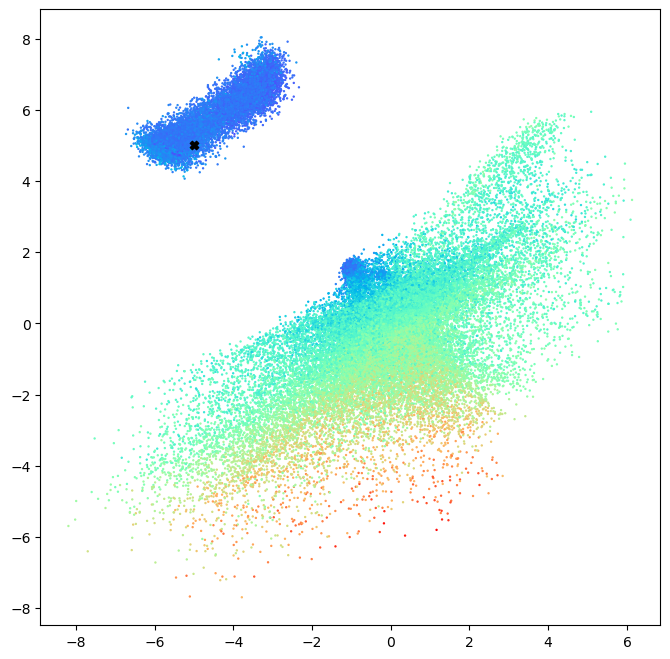

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(emb[:,0], emb[:,1],c=rmsd,s=0.5,cmap="rainbow")
plt.scatter(sample[:,0], sample[:,1], marker="X", c="Black")

plt.show()

# VAE

# Decode and visualize

In [77]:
s = decoder.predict(sample)
s_orig = scaler.inverse_transform(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [78]:
coords_flat = s_orig[0, :coords.shape[1]]                    
coords_recons = coords_flat.reshape((n_bb, 3))

In [79]:
new_traj = md.Trajectory(
    xyz=np.array([coords_recons]),     
    topology=rms_ref_bb.topology     
)



In [80]:
new_traj.save_pdb("reconstructed.pdb")

In [81]:
import nglview as nv

In [83]:
view = nv.show_file('reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()